In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

In [2]:
%%time
cols = ['ActualElapsedTime', 'CRSElapsedTime', 'Distance','AirTime','ArrDelay',
        'DepDelay', 'CRSDepTime', 'CRSArrTime', 'CarrierDelay', 'LateAircraftDelay', 'Origin', 'Dest','UniqueCarrier']


df = pd.read_csv('DelayedFlights.csv', usecols=cols)

CPU times: user 544 ms, sys: 65.7 ms, total: 610 ms
Wall time: 616 ms


In [3]:
df.head()

,CRSDepTime,CRSArrTime,UniqueCarrier,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,CarrierDelay,LateAircraftDelay
0,1955,2225,WN,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,NaN,NaN
1,735,1000,WN,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,NaN,NaN
2,620,750,WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,NaN,NaN
3,1755,1925,WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,2.0,32.0
4,1915,2110,WN,101.0,115.0,87.0,11.0,25.0,IND,JAX,688,NaN,NaN


In [4]:
dfpd = df.dropna()

In [5]:
dfpd.head()

,CRSDepTime,CRSArrTime,UniqueCarrier,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,CarrierDelay,LateAircraftDelay
3,1755,1925,WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,2.0,32.0
5,1830,1940,WN,240.0,250.0,230.0,57.0,67.0,IND,LAS,1591,10.0,47.0
7,1510,1725,WN,121.0,135.0,107.0,80.0,94.0,IND,MCO,828,8.0,72.0
9,1425,1625,WN,228.0,240.0,213.0,15.0,27.0,IND,PHX,1489,3.0,12.0
11,1255,1510,WN,123.0,135.0,110.0,16.0,28.0,IND,TPA,838,0.0,16.0


In [6]:
dfpd = dfpd.sample(frac=0.2) # XGBoost requires a bit of RAM, we need a larger cluster

is_delayed_col = (dfpd.DepDelay.fillna(16) > 15)  # column of labels
del dfpd['DepDelay']  # Remove delay information from training dataframe

dfpd['CRSDepTime'] = dfpd['CRSDepTime'].clip(upper=2399)
dfpd['CRSArrTime'] = dfpd['CRSArrTime'].clip(upper=2399)

In [7]:
dfpd.head()

,CRSDepTime,CRSArrTime,UniqueCarrier,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,Origin,Dest,Distance,CarrierDelay,LateAircraftDelay
53684,1640,1740,OO,56.0,60.0,35.0,32.0,SLC,GJT,217,32.0,0.0
53212,1828,1936,OO,89.0,68.0,52.0,187.0,FAT,LAX,209,187.0,0.0
144702,1125,1240,9E,69.0,75.0,52.0,163.0,BTR,MEM,319,0.0,163.0
177635,2020,2327,CO,243.0,247.0,224.0,24.0,LGA,IAH,1416,0.0,24.0
238726,1640,1859,OH,196.0,199.0,139.0,41.0,JFK,ORD,740,41.0,0.0


In [8]:
dfpd.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48586 entries, 53684 to 236283
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CRSDepTime         48586 non-null  int64  
 1   CRSArrTime         48586 non-null  int64  
 2   UniqueCarrier      48586 non-null  object 
 3   ActualElapsedTime  48586 non-null  float64
 4   CRSElapsedTime     48586 non-null  float64
 5   AirTime            48586 non-null  float64
 6   ArrDelay           48586 non-null  float64
 7   Origin             48586 non-null  object 
 8   Dest               48586 non-null  object 
 9   Distance           48586 non-null  int64  
 10  CarrierDelay       48586 non-null  float64
 11  LateAircraftDelay  48586 non-null  float64
dtypes: float64(6), int64(3), object(3)
memory usage: 4.8+ MB


In [9]:
categorical_cols = ['UniqueCarrier', 'Origin', 'Dest']

X = pd.get_dummies(dfpd, columns=categorical_cols)

In [10]:
X.head()

,CRSDepTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,Distance,CarrierDelay,LateAircraftDelay,UniqueCarrier_9E,...,Dest_TXK,Dest_TYR,Dest_TYS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM
53684,1640,1740,56.0,60.0,35.0,32.0,217,32.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
53212,1828,1936,89.0,68.0,52.0,187.0,209,187.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
144702,1125,1240,69.0,75.0,52.0,163.0,319,0.0,163.0,1,...,0,0,0,0,0,0,0,0,0,0
177635,2020,2327,243.0,247.0,224.0,24.0,1416,0.0,24.0,0,...,0,0,0,0,0,0,0,0,0,0
238726,1640,1859,196.0,199.0,139.0,41.0,740,41.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
is_delayed_col.head()

53684     True
53212     True
144702    True
177635    True
238726    True
Name: DepDelay, dtype: bool

In [12]:
%%time
# X= dfpd
y = is_delayed_col

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)

CPU times: user 248 ms, sys: 24.6 ms, total: 272 ms
Wall time: 527 ms


In [13]:
%%time
from xgboost import XGBClassifier

classifier = XGBClassifier(tree_method="gpu_hist", enable_categorical=True)
classifier.fit(X_train, y_train)

CPU times: user 6.48 s, sys: 402 ms, total: 6.88 s
Wall time: 7.13 s


In [14]:
print(classifier)

XGBClassifier(enable_categorical=True, tree_method='gpu_hist')


In [15]:
%%time

y_pred = classifier.predict(X_test)
predictions = [value for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.33%
CPU times: user 66.3 ms, sys: 29.6 ms, total: 95.9 ms
Wall time: 98.5 ms


ROC_AUC Score :  0.858748639060078


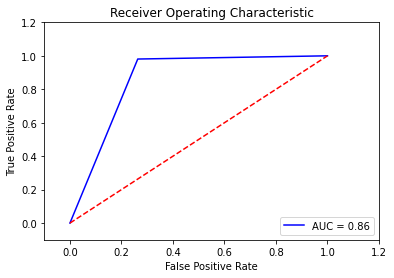

In [16]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def create_roc_curve(labels, scores):
  fpr, tpr, thresholds = metrics.roc_curve(labels, scores)
  roc_auc = metrics.auc(fpr, tpr)
  print("ROC_AUC Score : ",roc_auc)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
  plt.legend(loc='lower right')
  plt.plot([0,1],[0,1],'r--')
  plt.xlim([-0.1,1.2])
  plt.ylim([-0.1,1.2])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

# y = np.array([0, 0, 1, 1])
# scores = np.array([0.1, 0.4, 0.35, 0.8])

create_roc_curve(y_test, predictions)

### Setting Parameters while Performing XGBoost

In [17]:
%%time

import numpy as np
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import dump_svmlight_file
# from sklearn.externals import joblib
from sklearn.metrics import precision_score

# data_train, data_test = df.random_split([0.9, 0.1], random_state=1234)
# labels_train, labels_test = is_delayed.random_split([0.9, 0.1], random_state=1234)

# use DMatrix for xgbosot
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)



# set xgboost params
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3,
    'eval_metric':'mlogloss'}  # the number of classes that exist in this datset
num_round = 200  # the number of training iterations

# param = {'objective': 'binary:logistic', 'nround': 1000,
#           'max_depth': 16, 'eta': 0.01, 'subsample': 0.5,
#           'min_child_weight': 1, 'tree_method': 'hist',
#           'grow_policy': 'lossguide'}



#------------- numpy array ------------------
# training and testing - numpy matrices
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)

# extracting most confident predictions
best_preds = np.asarray([np.argmax(line) for line in preds])
print ("Numpy array precision:", precision_score(y_test, best_preds, average='macro'))

Numpy array precision: 0.9668703272923074
CPU times: user 3min 52s, sys: 709 ms, total: 3min 53s
Wall time: 3min 52s
